In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
%matplotlib widget

In [2]:
import addict
import colorcet as cc
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib import collections
from matplotlib.colors import Normalize
from importlib import reload
from typing import List, Dict, Tuple
import celeri

plt.rcParams["text.usetex"] = False

# Read input, create data structures, close blocks


In [3]:
COMMAND_FILE_NAME = "../data/command/anatolia_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-07-10 15:43:09.300 | INFO     | celeri.celeri:get_logger:5735 - Read: ../data/command/anatolia_command.json
2024-07-10 15:43:09.301 | INFO     | celeri.celeri:get_logger:5736 - RUN_NAME: 0000000003
2024-07-10 15:43:09.301 | INFO     | celeri.celeri:get_logger:5737 - Write log file: ../runs/0000000003/0000000003.log
2024-07-10 15:43:09.301 | INFO     | celeri.celeri:read_data:296 - Reading data files
2024-07-10 15:43:09.307 | SUCCESS  | celeri.celeri:read_data:300 - Read: ../data/segment/anatolia_segment_0035.csv
2024-07-10 15:43:09.309 | SUCCESS  | celeri.celeri:read_data:305 - Read: ../data/block/anatolia_0035_block.csv
2024-07-10 15:43:09.309 | SUCCESS  | celeri.celeri:read_data:312 - Read: ../data/mesh/anatolia_mesh_parameters.json

2024-07-10 15:43:09.430 | SUCCESS  | celeri.celeri:read_data:458 - Read: ../data/mesh/north_anatolian_fault_4328.msh
2024-07-10 15:43:09.439 | SUCCESS  | celeri.celeri:read_data:494 - Read: ../data/station/weiss_gbm_train_naf_localized_subset.csv
20

# Get elastic operators and TDE smoothing operators


In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-07-10 15:43:16.811 | INFO     | celeri.celeri:get_elastic_operators:1648 - Using precomputed elastic operators


# Calculate non-elastic operators


In [6]:
n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, n_blocks
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-07-10 15:43:20.645 | INFO     | celeri.celeri:get_slip_rate_constraints:2877 - Found 5 slip rate constraints
2024-07-10 15:43:20.645 | INFO     | celeri.celeri:get_slip_rate_constraints:2900 - Tensile-slip rate constraint on 11: rate = 0.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)
2024-07-10 15:43:20.646 | INFO     | celeri.celeri:get_slip_rate_constraints:2900 - Tensile-slip rate constraint on 11: rate = 0.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr)
2024-07-10 15:43:20.646 | INFO     | celeri.celeri:get_slip_rate_constraints:2880 - Strike-slip rate constraint on Akar_connect2: rate = -8.00 (mm/yr), 1-sigma uncertainty = +/-5.00 (mm/yr)
2024-07-10 15:43:20.649 | INFO     | celeri.celeri:get_slip_rate_constraints:2900 - Tensile-slip rate constraint on Rhod_connect2: rate = -10.00 (mm/yr), 1-sigma uncertainty = +/-20.00 (mm/yr)
2024-07-10 15:43:20.650 | INFO     | celeri.celeri:get_slip_rate_constraints:2900 - Tensile-slip rate constraint on newb: rate = 0.00 (mm/yr), 1-

# Plot input data


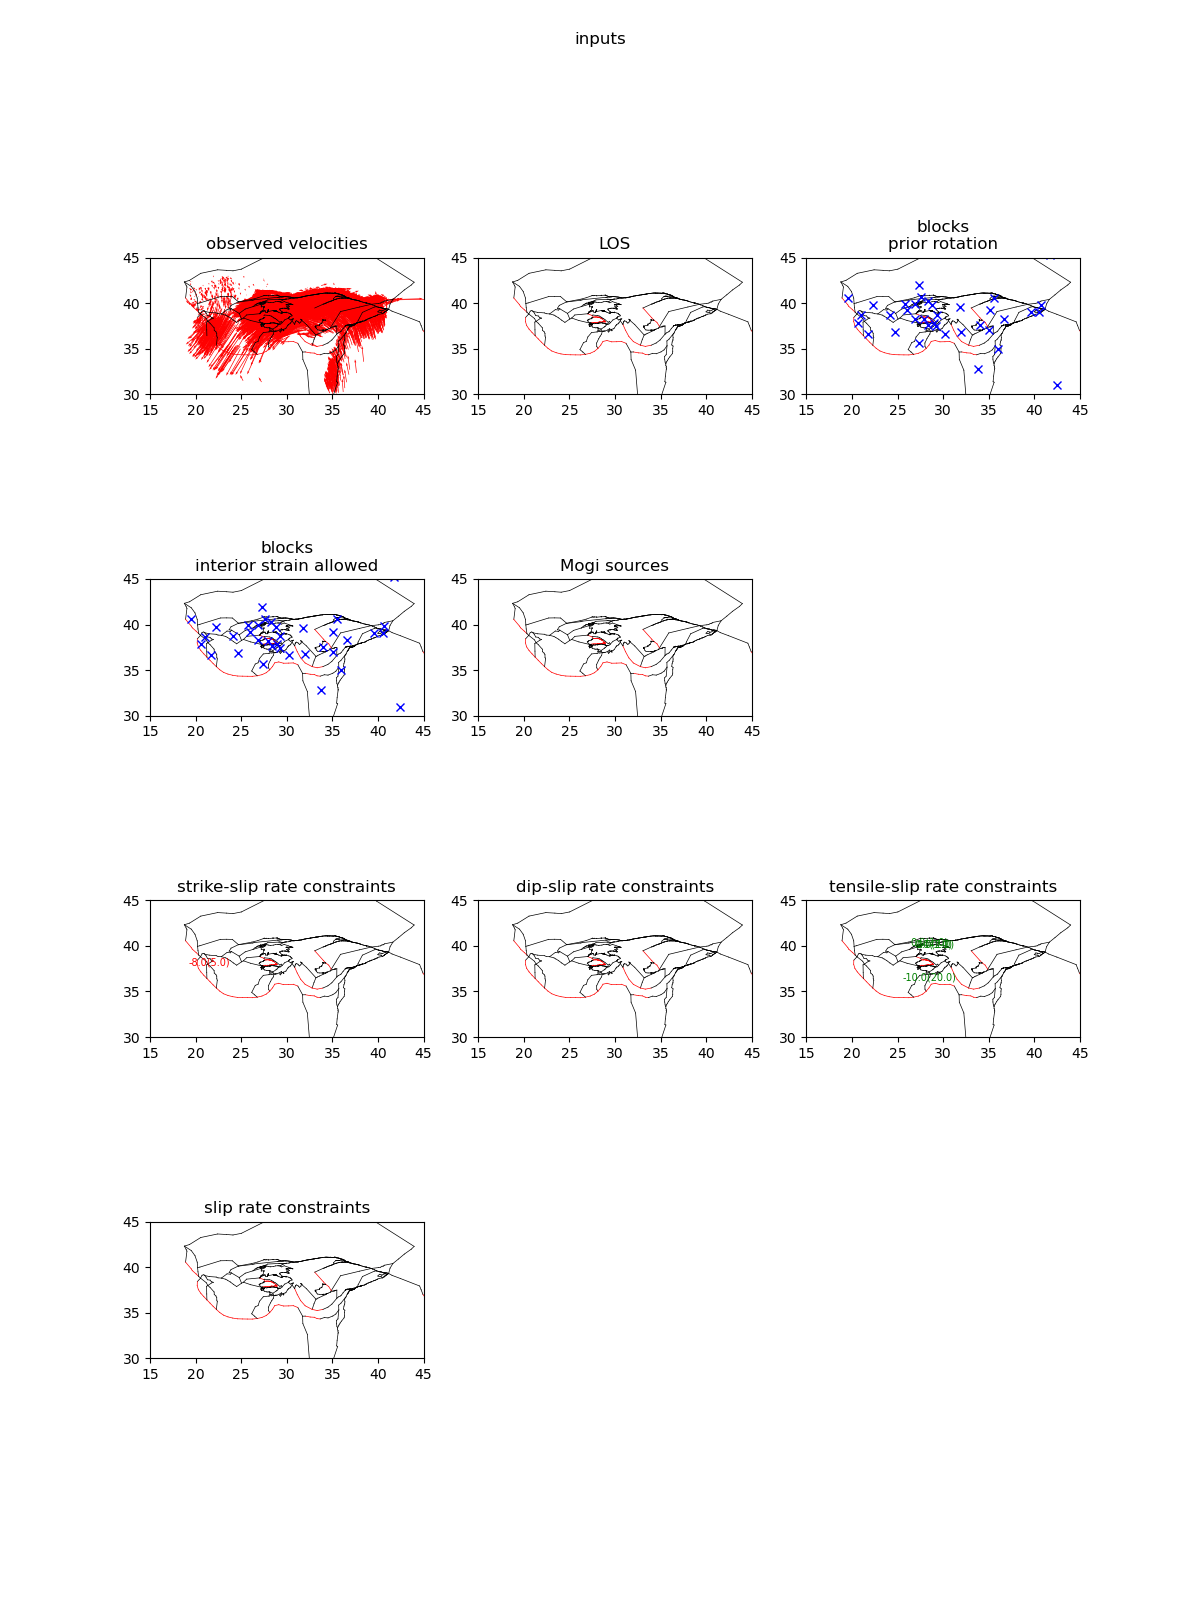

2024-07-10 15:43:30.214 | SUCCESS  | celeri.celeri:plot_input_summary:5109 - Wrote figures../runs/0000000003/plot_input_summary.(pdf, png)


In [7]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Estimate block model parameters (dense)


In [8]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary


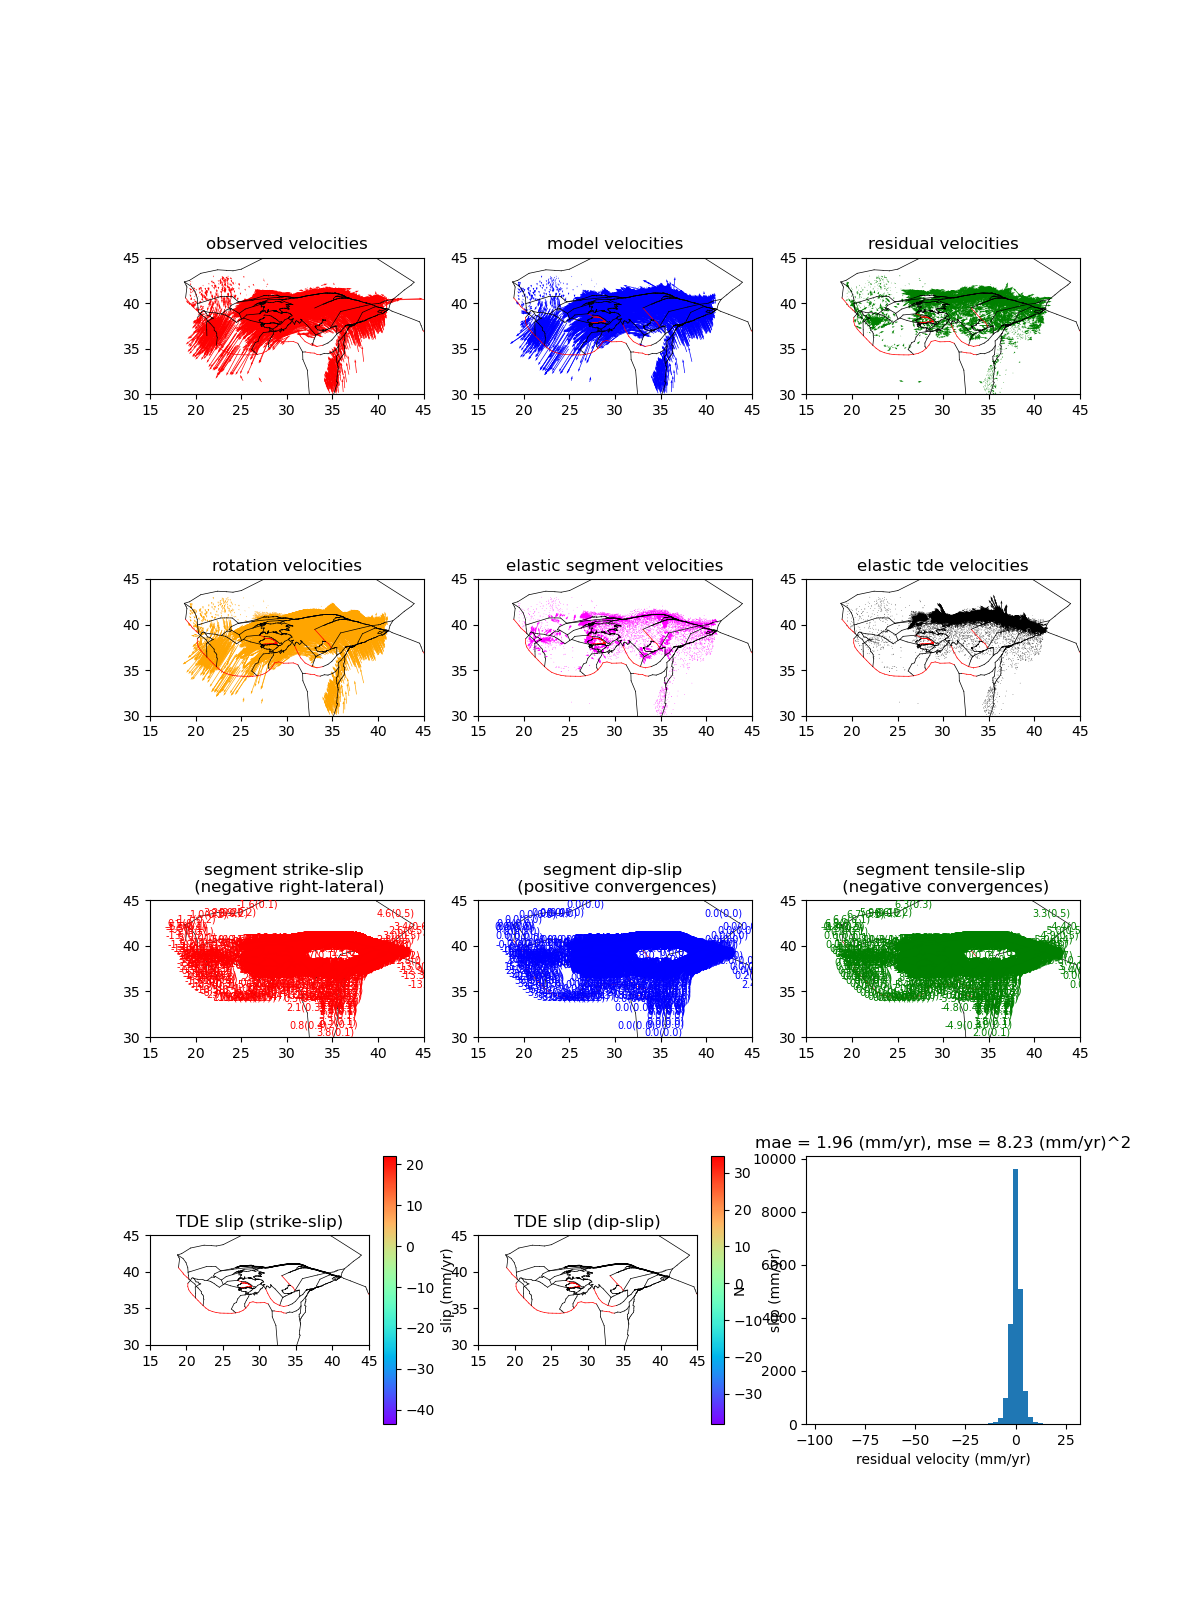

2024-07-10 15:44:29.999 | SUCCESS  | celeri.celeri:plot_estimation_summary:5449 - Wrote figures../runs/0000000003/plot_estimation_summary.(pdf, png)


In [9]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Standard plots

- Note that there are very few magic numbers here. The reason for this is that these values apply to almost all of the plots that follow so that by defining them up at the top we can make a single change and all figures are updated.


In [11]:
WORLD_BOUNDARIES = sio.loadmat("WorldHiVectors.mat")
FIGSIZE_VECTORS = (15, 8)
FONTSIZE = 16
LON_RANGE = (25, 42)
LAT_RANGE = (34, 43)
LON_TICKS = [25, 27, 29, 31, 33, 35, 37, 39, 41]
LAT_TICKS = [34, 36, 38, 40, 42]
SLIP_RATE_MIN = -25.0
SLIP_RATE_MAX = 25.0
LAND_COLOR = "lightgray"
LAND_LINEWIDTH = 0.5
LAND_ZORDER = 0
KEY_RECTANGLE_ANCHOR = [39, 34]
KEY_RECTANGLE_WIDTH = 3.0
KEY_RECTANGLE_HEIGHT = 1.55
KEY_ARROW_LON = 40.5
KEY_ARROW_LAT = 34.5
KEY_ARROW_MAGNITUDE = 25.0
KEY_ARROW_TEXT = "25 mm/yr"
KEY_ARROW_COLOR = "k"
KEY_BACKGROUND_COLOR = "white"
KEY_LINEWIDTH = 1.0
KEY_EDGECOLOR = "k"
ARROW_MAGNITUDE_MIN = 0.0
ARROW_MAGNITUDE_MAX = 25.0
ARROW_COLORMAP = cm.plasma
ARROW_SCALE = 100
ARROW_WIDTH = 0.0025
ARROW_LINEWIDTH = 0.5
ARROW_EDGECOLOR = "k"
SEGMENT_LINE_WIDTH_OUTER = 2.0
SEGMENT_LINE_WIDTH_INNER = 1.0
SEGMENT_LINE_COLOR_OUTER = "k"
SEGMENT_LINE_COLOR_INNER = "w"

In [12]:
def common_plot_elements(segment: pd.DataFrame, lon_range: Tuple, lat_range: Tuple):
    """Elements common to all subplots
    Args:
        segment (pd.DataFrame): Fault segments
        lon_range (Tuple): Longitude range (min, max)
        lat_range (Tuple): Latitude range (min, max)
    """
    for i in range(len(segment)):
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-k",
            linewidth=SEGMENT_LINE_WIDTH_OUTER,
        )
    for i in range(len(segment)):
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-w",
            linewidth=SEGMENT_LINE_WIDTH_INNER,
        )

    plt.xlim([lon_range[0], lon_range[1]])
    plt.ylim([lat_range[0], lat_range[1]])
    plt.xticks(LON_TICKS)
    plt.yticks(LAT_TICKS)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("longitude (degrees)", fontsize=FONTSIZE)
    plt.ylabel("latitude (degrees)", fontsize=FONTSIZE)
    plt.tick_params(labelsize=FONTSIZE)


def plot_vel_arrows_elements(east_velocity, north_velocity, arrow_scale):
    # Draw velocity vectors
    velocity_magnitude = np.sqrt(east_velocity**2.0 + north_velocity**2.0)
    norm = Normalize()
    norm.autoscale(velocity_magnitude)
    norm.vmin = ARROW_MAGNITUDE_MIN
    norm.vmax = ARROW_MAGNITUDE_MAX
    colormap = ARROW_COLORMAP
    quiver_handle = plt.quiver(
        station.lon,
        station.lat,
        east_velocity,
        north_velocity,
        scale=ARROW_SCALE * arrow_scale,
        width=ARROW_WIDTH,
        scale_units="inches",
        color=colormap(norm(velocity_magnitude)),
        linewidth=ARROW_LINEWIDTH,
        edgecolor=ARROW_EDGECOLOR,
    )

    # Draw land
    plt.fill(
        WORLD_BOUNDARIES["lon"],
        WORLD_BOUNDARIES["lat"],
        color=LAND_COLOR,
        linewidth=LAND_LINEWIDTH,
        zorder=LAND_ZORDER,
    )

    # Draw white background rectangle
    rect = mpatches.Rectangle(
        KEY_RECTANGLE_ANCHOR,
        KEY_RECTANGLE_WIDTH,
        KEY_RECTANGLE_HEIGHT,
        fill=True,
        color=KEY_BACKGROUND_COLOR,
        linewidth=KEY_LINEWIDTH,
        ec=KEY_EDGECOLOR,
    )
    plt.gca().add_patch(rect)

    # # Draw arrow legend
    plt.quiverkey(
        quiver_handle,
        KEY_ARROW_LON,
        KEY_ARROW_LAT,
        KEY_ARROW_MAGNITUDE,
        KEY_ARROW_TEXT,
        coordinates="data",
        color=KEY_ARROW_COLOR,
        fontproperties={"size": FONTSIZE},
    )

    plt.gca().set_aspect("equal")
    plt.show()

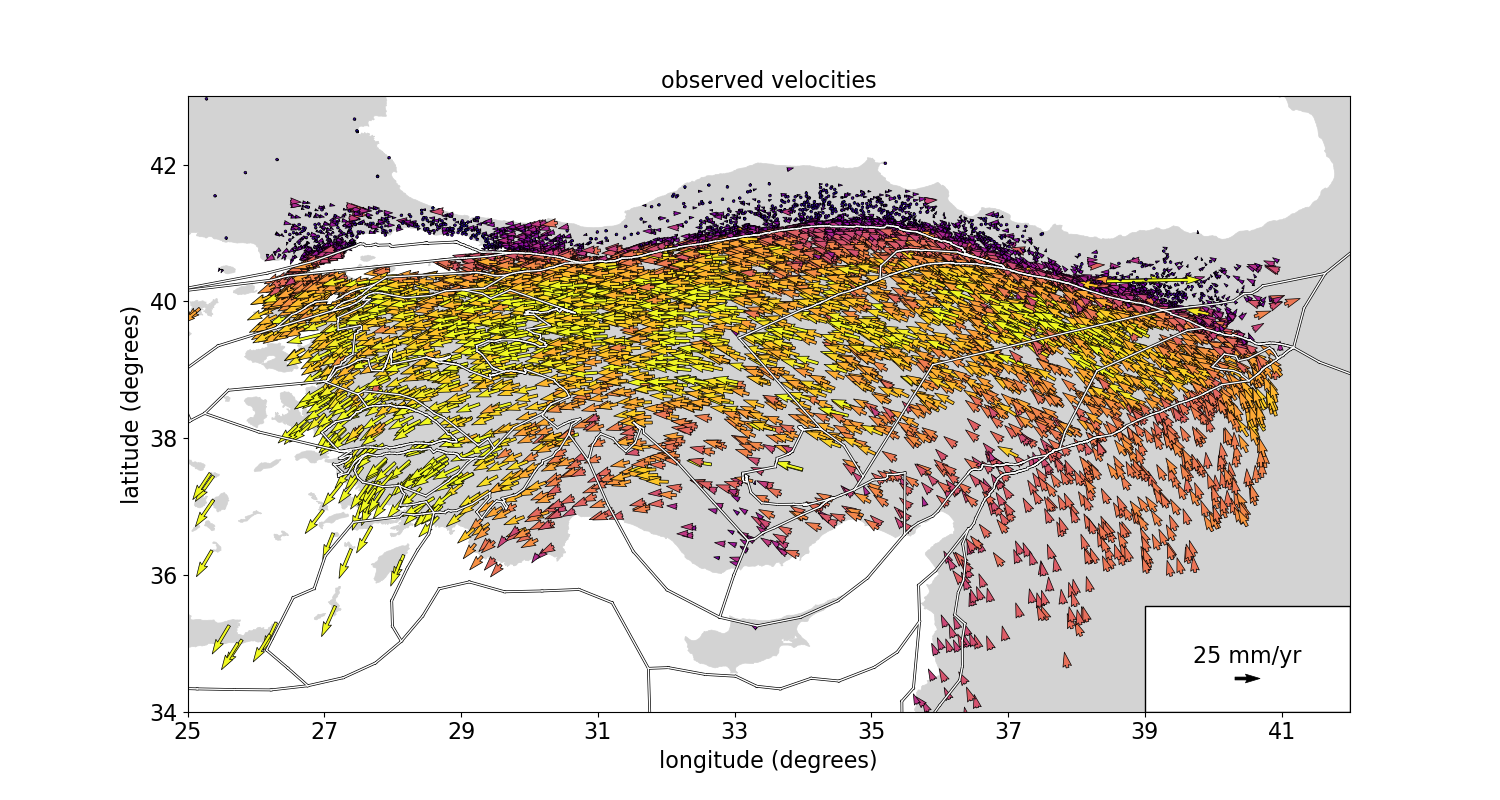

In [13]:
# Observed velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("observed velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(station.east_vel, station.north_vel, arrow_scale=1.0)

In [ ]:
# Model velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("model velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(estimation.east_vel, estimation.north_vel, arrow_scale=1.0)

In [ ]:
# Residual velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("residual velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(
    estimation.east_vel_residual, estimation.north_vel_residual, arrow_scale=0.25
)

In [ ]:
# Rotation velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("rotation velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(
    estimation.east_vel_rotation, estimation.north_vel_rotation, arrow_scale=1.0
)

In [ ]:
# Elastic segment velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("elastic segment velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(
    estimation.east_vel_elastic_segment,
    estimation.north_vel_elastic_segment,
    arrow_scale=0.25,
)

In [ ]:
# Elastic tde velocities
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("elastic mesh velocities", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)
plot_vel_arrows_elements(
    estimation.east_vel_tde, estimation.north_vel_tde, arrow_scale=0.25
)

In [ ]:
# Residual velocities
residual_velocity_vector = np.concatenate(
    (estimation.east_vel_residual.values, estimation.north_vel_residual.values)
)
mean_average_error = np.mean(np.abs(residual_velocity_vector))

N_BINS = 100
BIN_EDGE_MIN = -15
BIN_EDGE_MAX = 15
BINS = np.linspace(BIN_EDGE_MIN, BIN_EDGE_MAX, N_BINS)

# Create histogram of residual velocities
plt.figure(figsize=(8, 4))
plt.hist(
    residual_velocity_vector,
    BINS,
    histtype="stepfilled",
    color="lightblue",
    edgecolor="k",
)
plt.xlim([BIN_EDGE_MIN, BIN_EDGE_MAX])
plt.xlabel("residual velocity (mm/yr)", fontsize=FONTSIZE)
plt.ylabel("N", fontsize=FONTSIZE)
plt.title(f"MAE = {mean_average_error:.2f} (mm/yr)", fontsize=FONTSIZE)
plt.tick_params(labelsize=FONTSIZE)
plt.show()

In [ ]:
# Scatter plot for velocity estimate errors
mae_station = np.abs(estimation.east_vel_residual.values) + np.abs(
    estimation.north_vel_residual.values
)
fig = plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("residual velocities", fontsize=16)
plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color=LAND_COLOR,
    linewidth=LAND_LINEWIDTH,
    zorder=LAND_ZORDER,
)

plt.scatter(
    station.lon,
    station.lat,
    s=25,
    edgecolors="k",
    c=mae_station,
    cmap="YlOrRd",
    linewidths=0.1,
)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)

# cbar = plt.colorbar(label="absolute error", shrink=0.45)
plt.clim(0, 10)

# Draw white background rectangle
rect = mpatches.Rectangle(
    KEY_RECTANGLE_ANCHOR,
    KEY_RECTANGLE_WIDTH,
    KEY_RECTANGLE_HEIGHT,
    fill=True,
    color=KEY_BACKGROUND_COLOR,
    linewidth=KEY_LINEWIDTH,
    ec=KEY_EDGECOLOR,
)
plt.gca().add_patch(rect)
plt.show()

In [ ]:
# Plot estimated strike-slip rates
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("strike-slip rates", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)

plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color=LAND_COLOR,
    linewidth=LAND_LINEWIDTH,
    zorder=LAND_ZORDER,
)

for i in range(len(segment)):
    if estimation.strike_slip_rates[i] < 0:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-r",
            linewidth=estimation.strike_slip_rates[i],
        )
    else:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-b",
            linewidth=estimation.strike_slip_rates[i],
        )

# Legend
black_segments = mlines.Line2D(
    [],
    [],
    color="red",
    marker="s",
    linestyle="None",
    markersize=10,
    label="right-lateral (10 mm/yr)",
)
red_segments = mlines.Line2D(
    [],
    [],
    color="blue",
    marker="s",
    linestyle="None",
    markersize=10,
    label="left-lateral (10 mm/yr)",
)
plt.legend(
    handles=[black_segments, red_segments],
    loc="lower right",
    fontsize=FONTSIZE,
    framealpha=1.0,
    edgecolor="k",
).get_frame().set_boxstyle("Square")

In [ ]:
# Plot estimated strike-slip rates
plt.figure(figsize=FIGSIZE_VECTORS)
plt.title("dip-slip/tensile-slip rates", fontsize=FONTSIZE)
common_plot_elements(segment, LON_RANGE, LAT_RANGE)

plt.fill(
    WORLD_BOUNDARIES["lon"],
    WORLD_BOUNDARIES["lat"],
    color=LAND_COLOR,
    linewidth=LAND_LINEWIDTH,
    zorder=LAND_ZORDER,
)

for i in range(len(segment)):
    if estimation.dip_slip_rates[i] > 0:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-r",
            linewidth=estimation.dip_slip_rates[i],
        )
    else:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-b",
            linewidth=estimation.dip_slip_rates[i],
        )

for i in range(len(segment)):
    if estimation.tensile_slip_rates[i] < 0:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-r",
            linewidth=estimation.tensile_slip_rates[i],
        )
    else:
        plt.plot(
            [segment.lon1[i], segment.lon2[i]],
            [segment.lat1[i], segment.lat2[i]],
            "-b",
            linewidth=estimation.tensile_slip_rates[i],
        )


# Legend
black_segments = mlines.Line2D(
    [],
    [],
    color="red",
    marker="s",
    linestyle="None",
    markersize=10,
    label="convergence (10 mm/yr)",
)
red_segments = mlines.Line2D(
    [],
    [],
    color="blue",
    marker="s",
    linestyle="None",
    markersize=10,
    label="extension (10 mm/yr)",
)
plt.legend(
    handles=[black_segments, red_segments],
    loc="lower right",
    fontsize=FONTSIZE,
    framealpha=1.0,
    edgecolor="k",
).get_frame().set_boxstyle("Square")